In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from preprocessing import StandardScaler, Split
from model import Regressor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
epochs = 200
batch_size = 512
best_model = np.inf

In [3]:
df = pd.read_csv('bdi.csv')
df.fillna(method='ffill', inplace=True)
data = df['bdi'].values

In [4]:
train = pd.read_csv('train.csv').drop(columns=['0']).values
val = pd.read_csv('val.csv').drop(columns=['0']).values
test = pd.read_csv('test.csv').drop(columns=['0']).values

In [5]:
y = np.array([data[i] for i in range(90, data.shape[0])]).reshape(-1,1)
x = np.array([data[i-30:i] for i in range(30, data.shape[0])]).reshape(-1,1,30)
x = np.array([x[i-61:i] for i in range(61, x.shape[0]+1)])

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y)

In [7]:
scaler = StandardScaler(y_train)
x_train = scaler.transform(x_train)
y_train = scaler.transform(y_train)
x_val = scaler.transform(x_val)
y_val = scaler.transform(y_val)
x_test = scaler.transform(x_test)

In [8]:
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)
x_test = torch.FloatTensor(x_test).to(device)

In [9]:
train = torch.LongTensor(train).to(device)
val = torch.LongTensor(val).to(device)
test = torch.LongTensor(test).to(device)

In [10]:
dataset = Data.TensorDataset(x_train, train, y_train)
dataloader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [11]:
model = Regressor().to(device)
print(model)

Regressor(
  (cnn0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(2,))
  (cnn1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
  (maxpool0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (ft): Flatten(start_dim=2, end_dim=-1)
  (lstm): LSTM(288, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=34, out_features=1, bias=True)
)


In [12]:
adam = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [13]:
history = dict()
history['loss'] = []
history['val_loss'] = []
for epoch in range(epochs):
    for x_batch, train_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch, train_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        adam.step()
        adam.zero_grad()
    with torch.no_grad():
        model.eval()
        y_pred = model(x_val, val)
        val_loss = criterion(y_pred, y_val)
    print(f'epoch:{epoch + 1:03d}-loss:{loss.item():.5f}-val_loss:{val_loss.item():.5f}')
    history['loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())
    if val_loss.item() <= best_model:
        best_model = val_loss
        torch.save(model, 'checkpoint_.pt')
        print('weight saved')
model = torch.load('checkpoint_.pt')

epoch:001-loss:0.07605-val_loss:0.03755
weight saved
epoch:002-loss:0.03078-val_loss:0.00489
weight saved
epoch:003-loss:0.01200-val_loss:0.00284
weight saved
epoch:004-loss:0.00532-val_loss:0.00223
weight saved
epoch:005-loss:0.00475-val_loss:0.00122
weight saved
epoch:006-loss:0.00278-val_loss:0.00255
epoch:007-loss:0.00253-val_loss:0.00097
weight saved
epoch:008-loss:0.00341-val_loss:0.00081
weight saved
epoch:009-loss:0.00238-val_loss:0.00070
weight saved
epoch:010-loss:0.00176-val_loss:0.00081
epoch:011-loss:0.00133-val_loss:0.00058
weight saved
epoch:012-loss:0.00462-val_loss:0.00187
epoch:013-loss:0.00199-val_loss:0.00052
weight saved
epoch:014-loss:0.00151-val_loss:0.00119
epoch:015-loss:0.00163-val_loss:0.00088
epoch:016-loss:0.00088-val_loss:0.00054
epoch:017-loss:0.00097-val_loss:0.00036
weight saved
epoch:018-loss:0.00106-val_loss:0.00034
weight saved
epoch:019-loss:0.00142-val_loss:0.00037
epoch:020-loss:0.00349-val_loss:0.00061
epoch:021-loss:0.00238-val_loss:0.00102
epoc

epoch:198-loss:0.00030-val_loss:0.00009
epoch:199-loss:0.00025-val_loss:0.00010
epoch:200-loss:0.00024-val_loss:0.00010


In [14]:
model.eval()
with torch.no_grad():
    predict = model(x_test, test).cpu().numpy()
    predict = scaler.inverse_transform(predict)

22.019998209635418

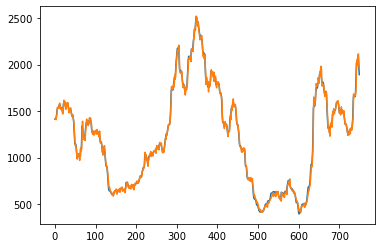

In [15]:
plt.plot(y_test)
plt.plot(predict)
metrics.mean_absolute_error(predict, y_test)

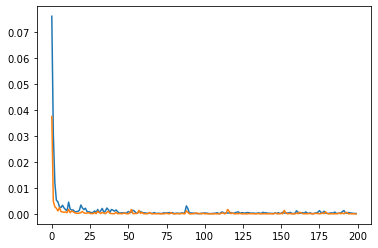

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])